# ODE  model of NeuroImaging with Bayesian Inference in Stan with cmdstanpy: MAP and ADVI
:::

:post: April 12, 2024
:tags: ODE model in Nympyro
:category: Advanced, how-to
:author: Nina BALDY, INS, AMU, Marseille.
:acknowledgment: Meysam HASHEMI

:::

In [1]:
import os
import sys
import time
import errno
import timeit
import pathlib
import pickle

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

import pandas as pd

from scipy.stats import norm
np.random.seed(0)

In [2]:
import cmdstanpy

In [3]:
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path)

In [4]:
from Helper.ERPhelper import *
from Helper.report_advi import convergence_advi, advi_elbo

In [5]:
print(f"Numpy version: {np.__version__}")
print(f"Arviz version: {az.__version__}")
print(f"Cmdstanpy version: {cmdstanpy.__version__}")

Numpy version: 1.26.4
Arviz version: 0.17.0
Cmdstanpy version: 1.1.0


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
az.style.use("arviz-darkgrid")
colors_l = ["#A4C3D9", "#7B9DBF", "#52779F", "#2A537E"] 

In [8]:
cwd = os.getcwd()
output_dir = cwd + '/output_cmdstanpy/'
! mkdir -p $output_dir
! mkdir -p $output_dir/output_advi
forward_dir = main_path + '/ForwardModel/'

In [9]:
def rmse(pred, target) :
    return np.sqrt(np.mean((pred-target)**2))

## Purpose


### Key Conclusions



## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simuations in the repo. The neural mass model used in this example has often been used in dynamical cuasal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The mode of Olivier David et al describes the interaction between theree neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

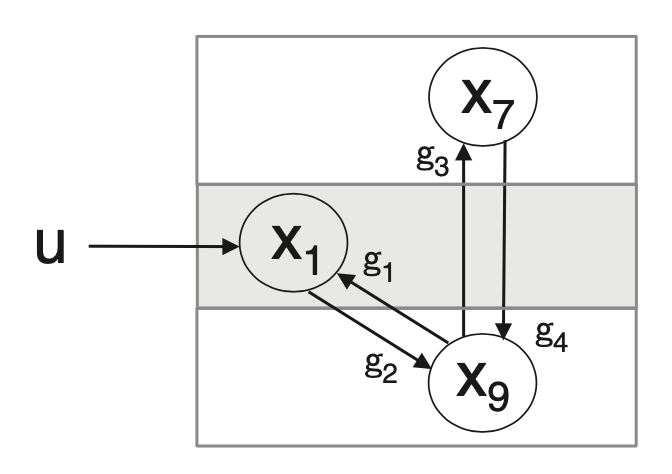

In [10]:
from IPython.display import Image
Image(filename=main_path + '/Images/model.png', width=400) 

This ODE given by:




\begin{array}{l}
\frac{dx_{1}(t)}{dt} = x_{4}(t) \\
\frac{dx_{2}(t)}{dt} = x_{5}(t) \\
\frac{dx_{3}(t)}{dt} = x_{6}(t) \\
\frac{dx_{7}(t)}{dt}  = x_{8}(t) \\
\frac{dx_{4}(t)}{dt} = \frac{{h_{e}(g_{1}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5) + u)}}{{\tau_{e}}} - \frac{{x_{1}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{4}(t)}}{{\tau_{e}}} \\
\frac{dx_{5}(t)}{dt}  = \frac{{g_{2}(\frac{1}{e^{-0.56x_{1}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{2}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{5}(t)}}{{\tau_{e}}} \\
\frac{dx_{6}(t)}{dt}  = \frac{{g_{4}(\frac{1}{e^{-0.56x_{7}(t-\delta)}+1} - 0.5)}}{{\tau_{i}}} - \frac{{x_{3}(t)}}{{\tau_{i}^{2}}} - \frac{{2x_{6}^{t}}}{{\tau_{i}}} \\
\frac{dx_{8}(t)}{dt}  = \frac{{g_{3}(\frac{1}{e^{-0.56x_{9}(t-\delta)}+1} - 0.5)}}{{\tau_{e}}} - \frac{{x_{7}(t)}}{{\tau_{e}^{2}}} - \frac{{2x_{8}(t)}}{{\tau_{e}}} \\
\frac{dx_{9}(t)}{dt}  = x_{5}(t) - x_{6}(t)
\end{array}



The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of nerural populations.  Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.  

$x(0)$ is the initial values of the states needed to solve the ODE, and are fixed to zero for all variables. 


The unknown model parameters which represent the following:  
* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ are maximum amplitude of excitatory (e), and inhibitory (i) post-synaptic potential.
* $\tau_{e, i}$ are the excitatory (e), and inhibitory (i) rate-constant of the membrane,
* $u$  is the input to the neural population.

## Simulator

In [11]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

In [12]:
ns = 9
x_init=np.zeros((ns))

In [13]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]

In [14]:
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

## Synthetic Observation

We assume that we only have accessto the activity of pyramidfal neurons, and for the sake of sppeding the computational time, we downsample the simuations.

In [15]:
#observation noise
sigma_true = 0.1 

In [16]:
#downsampling
ds=10

In [17]:
ts_obs=ts[::ds]

In [18]:
data_sim = { 'nt':nt//ds+1, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt*ds, 'ns': ns, 
        'x_init': x_init, 'obs_err': sigma_true, 'n_params': n_params, 'alpha': -0.56}

for iprm, prm in enumerate(my_var_names) :
    data_sim[prm] = theta_true[iprm]

we can simulate the data in stan

In [19]:
model_name = 'ERPmodel_Stan'
stanfile = os.path.join(forward_dir, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [20]:
forward_sim = model.sample(data=data_sim, iter_warmup=0, iter_sampling=1, chains=1)

11:45:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

11:45:09 - cmdstanpy - INFO - CmdStan done processing.


In [21]:
xpy_obs = forward_sim.stan_variable('x_hat_ppc').flatten()
xpy_model = forward_sim.stan_variable('x_hat_full').flatten()
xpy_model_ds = forward_sim.stan_variable('x_hat').flatten()

In [22]:
print(xpy_obs.shape)
print(xpy_model.shape)

(201,)
(2001,)


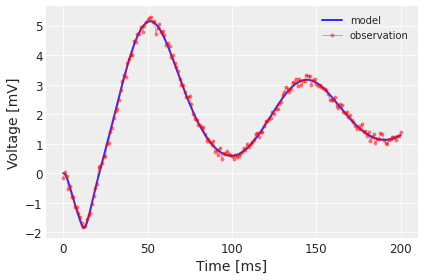

In [23]:
plot_observation(ts, xpy_model, ts_obs, xpy_obs)

In [24]:
data = data_sim.copy()
data['xpy_obs'] = xpy_obs
data['nt'] =  len(xpy_obs)

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].
The Gamma distribution has two parametrization: numpy.random.gamma uses the shape and scale parametrization, while stan uses the shape and rate.

In [25]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, scale=scale, rate=rate)

In [26]:
data['prior_gamma_shape'] = prior_specs['shape']
data['prior_gamma_rate'] = prior_specs['rate']

In [27]:
model_name = 'DCM_ERP_PriorPred_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [28]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    g_1 ~ gamma(prior_gamma_shape[1], prior_gamma_rate[1]);
    g_2 ~ gamma(prior_gamma_shape[2], prior_gamma_rate[2]);
    g_3 ~ gamma(prior_gam

In [29]:
n_= 100 
prior_pred = model.sample(data=data, iter_warmup=1000, iter_sampling=n_)

11:45:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:45:11 - cmdstanpy - INFO - CmdStan done processing.
11:45:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/mnt/data/tng/phd/DCM/DCM_ERP_new/github/Stan/NMM_EPR_Euler_full_ODE_PriorPred_GammaPrior.stan', line 49, column 4 to column 59)
Consider re-running with show_console=True if

In [30]:
prior_pred_samples = prior_pred.stan_variables()

In [31]:
prior_predictions = {'xpy_model': prior_pred_samples['x_hat']}
for key in my_var_names :
    prior_predictions[key] = prior_pred_samples[key]

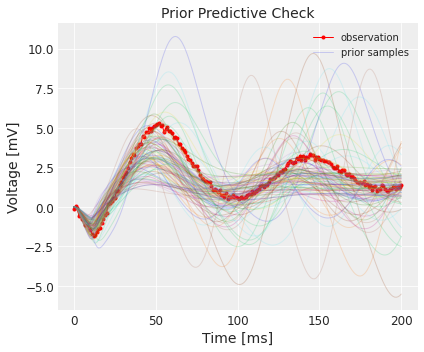

In [32]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title)

## Stan model

In [33]:
model_name = 'DCM_ERP_sampling_GammaPrior'
stanfile = os.path.join(cwd, model_name + '.stan')
model = cmdstanpy.CmdStanModel(stan_file=stanfile)
model.compile()

In [34]:
with open(stanfile) as f :
    print(f.read())

functions {
  real Sigmodal(real x1,  real x2, real delta, real alpha ) {
       real S=(1.0/(1.0+exp(alpha*(x1-(delta*x2)))))-0.5;
    return S;
  }
}


data {
  int ns;                                       
  int nt;
  real dt; 
  int ds;
  real alpha;    
  row_vector[nt] xpy_obs;  
  int n_params; 
  row_vector[n_params] prior_gamma_shape; 
  row_vector[n_params] prior_gamma_rate; 
  real obs_err;
}


transformed data {
   vector[ns] x_init;
   x_init=rep_vector(0.,ns);
  real dt_full = dt/ds;
  int nt_full = (nt-1)*ds + 1;

}

parameters{
    real<lower=0.0>  g_1;
    real<lower=0.0>  g_2;
    real<lower=0.0>  g_3;
    real<lower=0.0>  g_4;
    real<lower=0.0>  delta;
    real<lower=0.0>  tau_i;
    real<lower=0.0>  h_i;
    real<lower=0.0>  tau_e;
    real<lower=0.0>  h_e;
    real<lower=0.0>  u;
}

transformed parameters {
}

model {

    matrix[ns, nt_full] x;
    vector[ns] dx;
    array[nt] int nt_indexing = linspaced_int_array(nt, 1, nt_full);
    row_vector[nt] x_hat;    


# Optimization

Maximum likelihood optimization in Stan yeilds fast point estimate results. In the present case, we deal with multimodality in the inference process. We run maximum a posteriori for 100 repetitions, the inference falls into a local solution with bad fit to the data roughly 30% of the time.

In [40]:
times_map = []
n_map = 100

In [41]:
opt = []
for _ in range(n_map) :
    fit = None
    while fit is None :
        try :
            start = time.time()
            fit = model.optimize(data=data)
        except :
            continue
    opt.append(fit)
    times_map.append(time.time() - start)

14:54:52 - cmdstanpy - INFO - Chain [1] start processing
14:54:58 - cmdstanpy - INFO - Chain [1] done processing
14:54:58 - cmdstanpy - INFO - Chain [1] start processing
14:55:04 - cmdstanpy - INFO - Chain [1] done processing
14:55:04 - cmdstanpy - INFO - Chain [1] start processing
14:55:05 - cmdstanpy - INFO - Chain [1] done processing
14:55:05 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:07 - cmdstanpy - INFO - Chain [1] done processing
14:55:07 - cmdstanpy - INFO - Chain [1] start processing
14:55:10 - cmdstanpy - INFO - Chain [1] done processing
14:55:10 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - INFO - Chain [1] start processing
14:55:11 - cmdstanpy - INFO - Chain [1] done processing
14:55:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - ERROR - Chain [1] error: error dur

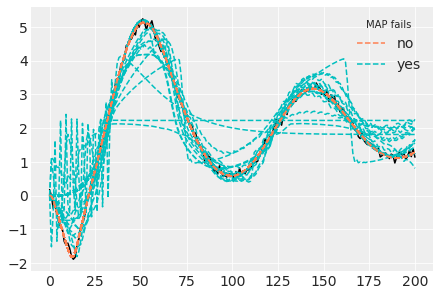

In [42]:
rmse_fit = []
rmse_prms = []
fails = []

fig, ax = plt.subplots()
ax.plot(data['xpy_obs'], '-k')

for o in opt :
    rmse_fit.append(rmse(o.stan_variable('x_hat'), data['xpy_obs']))
    rmse_prms.append(rmse([o.stan_variable(prm) for prm in my_var_names], theta_true))
    fail = bool(rmse_fit[-1] > 0.25 and rmse_prms[-1] > 5.5)
    color = ['coral', 'c'][fail]
    fails.append(fail)
    ax.plot(o.stan_variable('x_hat'), '--', color=color, label=['no', 'yes'][fail])
h, l = ax.get_legend_handles_labels()
unique_l, index = np.unique(l, return_index=True)
ax.legend(np.array(h)[index], unique_l, title='MAP fails');

In [43]:
print('Proportion of locally stuck inference', np.sum(fails) / len(fails))

Proportion of locally stuck inference 0.29


## Initilization in low probability region of the prior distributions

In [44]:
prior, low_prob_sample_vals, q_ = low_prob_sample(my_var_names, prior_predictions)

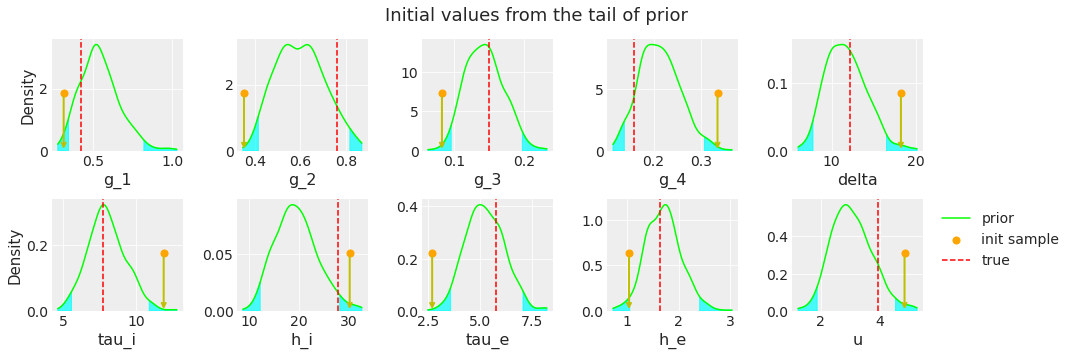

In [45]:
plot_prior_tail(my_var_names, theta_true, prior, low_prob_sample_vals, q_)

In [46]:
inits = dict(zip(my_var_names, low_prob_sample_vals))

# Optimization with initialization

When initializing in low probabiltiy of the priors, optimization escapes local minima and targets the relevant mode 100% of the time.

In [47]:
times_map = []
n_map = 10

In [48]:
opt = []
for _ in range(n_map) :
    fit = None
    while fit is None :
        try :
            start = time.time()
            fit = model.optimize(data=data, inits=inits)
        except :
            continue
    opt.append(fit)
    times_map.append(time.time() - start)

14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:12 - cmdstanpy - INFO - Chain [1] done processing
14:58:12 - cmdstanpy - INFO - Chain [1] start processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:14 - cmdstanpy - INFO - Chain [1] start processing
14:58:15 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing
14:58:16 - cmdstanpy - INFO - Chain [1] done processing
14:58:16 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing
14:58:17 - cmdstanpy - INFO - Chain [1] start processing
14:58:18 - cmdstanpy - INFO - Chain [1]

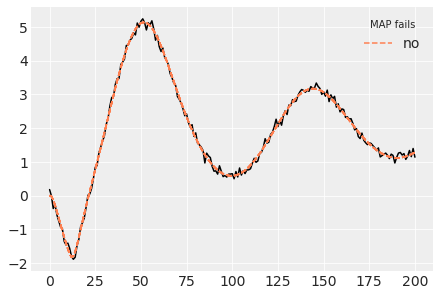

In [49]:
rmse_fit = []
rmse_prms = []
fails = []

fig, ax = plt.subplots()
ax.plot(data['xpy_obs'], '-k')

for o in opt :
    rmse_fit.append(rmse(o.stan_variable('x_hat'), data['xpy_obs']))
    rmse_prms.append(rmse([o.stan_variable(prm) for prm in my_var_names], theta_true))
    fail = bool(rmse_fit[-1] > 0.25 and rmse_prms[-1] > 5.5)
    color = ['coral', 'c'][fail]
    fails.append(fail)
    ax.plot(o.stan_variable('x_hat'), '--', color=color, label=['no', 'yes'][fail])
h, l = ax.get_legend_handles_labels()
unique_l, index = np.unique(l, return_index=True)
ax.legend(np.array(h)[index], unique_l, title='MAP fails');

In [50]:
print('Proportion of locally stuck inference', np.sum(fails) / len(fails))

Proportion of locally stuck inference 0.0


In [ ]:
with open(output_dir + 'values_map_with_inits.pkl', 'wb') as f:
    pickle.dump(dict(zip(my_var_names, [opt[0].stan_variables()[prm] for prm in my_var_names])), f)

# Automatic Differentiation Variational Inference - mean field

We run ADVI with intilization. Without initilization, roughly half of the runs result in non convergence. As encountered in HMC, within "converged" runs, convergence to the relevant mode is not guaranteed. 
With initialization, all runs are considered to have run to their end, however this does not guarantee that the results of the runs are consistent, nor that they are targeting the true generative process.

In [51]:
alg = 'mean_field'
advi_output_dir =  output_dir + 'output_advi/' + alg + '/'
print(advi_output_dir)

/mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_advi/mean_field/


In [52]:
nadvi = 10

In [58]:
for i in range(nadvi) :
    try :
        model.variational(data=data, inits=inits, output_dir=advi_output_dir, iter=200000, 
                          tol_rel_obj=0.00001, require_converged=False)
    except :
        model.variational(data=data, inits=inits, output_dir=advi_output_dir, iter=200000, 
                          tol_rel_obj=0.00001, require_converged=False)

12:56:15 - cmdstanpy - INFO - Chain [1] start processing
13:06:23 - cmdstanpy - INFO - Chain [1] done processing
13:06:23 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
13:06:30 - cmdstanpy - INFO - Chain [1] start processing
13:16:19 - cmdstanpy - INFO - Chain [1] done processing
13:16:19 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
13:16:25 - cmdstanpy - INFO - Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:34:18 - cmdstanpy - INFO - Chain [1] done processing
13:34:18 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
13:34:24 - cmdstanpy - INFO - Chain [1] start proces

In [59]:
converged = np.zeros(nadvi)
files_converged = []
ELBO_advi = []

i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)
ELBO_advi = np.array(ELBO_advi)

In [60]:
index_cv = np.argwhere(converged == 1).flatten()
n_advi_converged = int(np.sum(converged))
pct_advi_converged = n_advi_converged / len(converged)
print('Percent of ADVI runs converged:', pct_advi_converged * 100)

Percent of ADVI runs converged: 100.0


Algorithm runs until the end, however it does not guarantee convergence. Based on ELBO shape, we discard the last run.

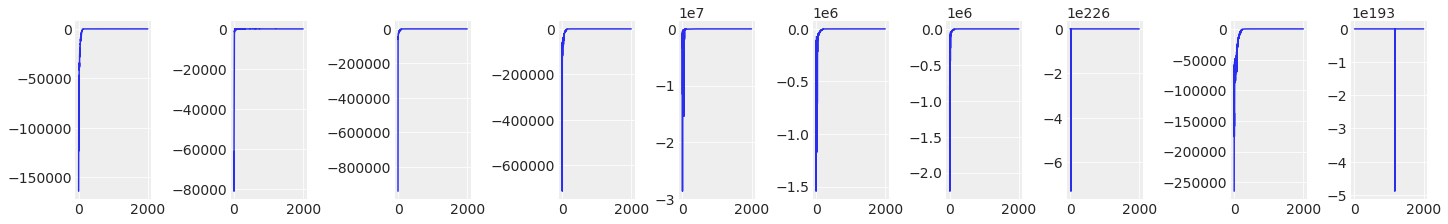

In [61]:
fig, ax = plt.subplots(ncols=n_advi_converged, figsize=(20, 3))
for i in range(n_advi_converged) :
    ax[i].plot(ELBO_advi[i, :])

In [62]:
az_obj = az.from_cmdstan([advi_output_dir + file + '.csv' for file in files_converged[:-1]])

In [63]:
az.summary(az_obj, var_names=my_var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
g_1     0.509  0.107   0.320    0.710      0.001    0.001    9025.0    8643.0   
g_2     0.645  0.016   0.608    0.663      0.005    0.004      10.0      22.0   
g_3     0.128  0.006   0.115    0.140      0.002    0.002      10.0      22.0   
g_4     0.218  0.002   0.214    0.223      0.001    0.001      11.0      22.0   
delta  12.311  0.031  12.255   12.371      0.004    0.003      50.0     138.0   
tau_i   7.658  0.027   7.605    7.707      0.001    0.001     321.0    7539.0   
h_i    20.466  0.429  19.456   21.188      0.141    0.103      10.0      22.0   
tau_e   5.733  0.012   5.709    5.755      0.002    0.001      45.0     118.0   
h_e     1.910  0.047   1.857    2.025      0.016    0.011      10.0      23.0   
u       3.498  0.528   2.589    4.542      0.006    0.004    8666.0    9148.0   

       r_hat  
g_1     1.00  
g_2     3.63  
g_3     3.81  
g_4     2.49  
delta   1.12  
tau_i   1.02  
h_i     3.19  
tau_e   1.13  
h_e     3.53  
u       1.00

In [64]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

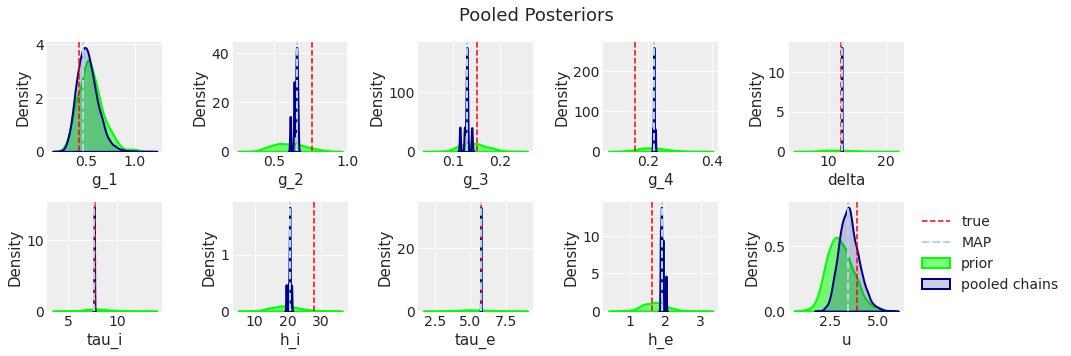

In [65]:
title="Pooled Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title);

### Fit and Posterior predictive check 

In [66]:
az_obj.posterior['xpy_model'] = az_obj.posterior['x_hat']

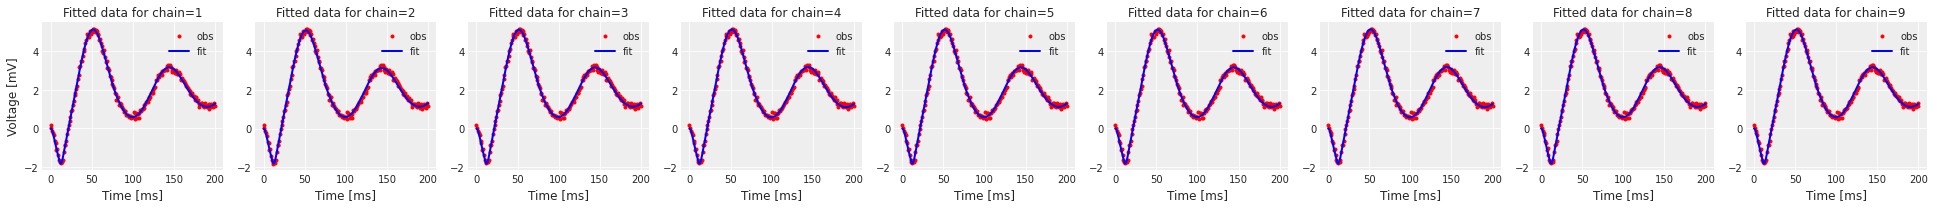

In [67]:
plot_fitted(data, az_obj.posterior);

In [68]:
ppc_= az_obj.posterior['x_hat_ppc']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=(0, 1))
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=(0, 1))

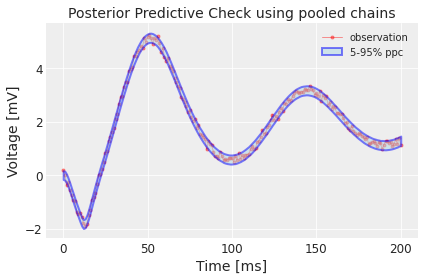

In [69]:
title='Posterior Predictive Check using pooled chains'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)

In [70]:
pooled_az_4 = az_obj.sel(chain=range(4), draw=range(200)).stack({'pooled_draw': ["chain", "draw"]})

In [ ]:
with open(output_dir + 'values_' + alg + '_with_inits.pkl', 'wb') as f:
    pickle.dump(pooled_az_4.posterior[my_var_names].to_pandas(), f)

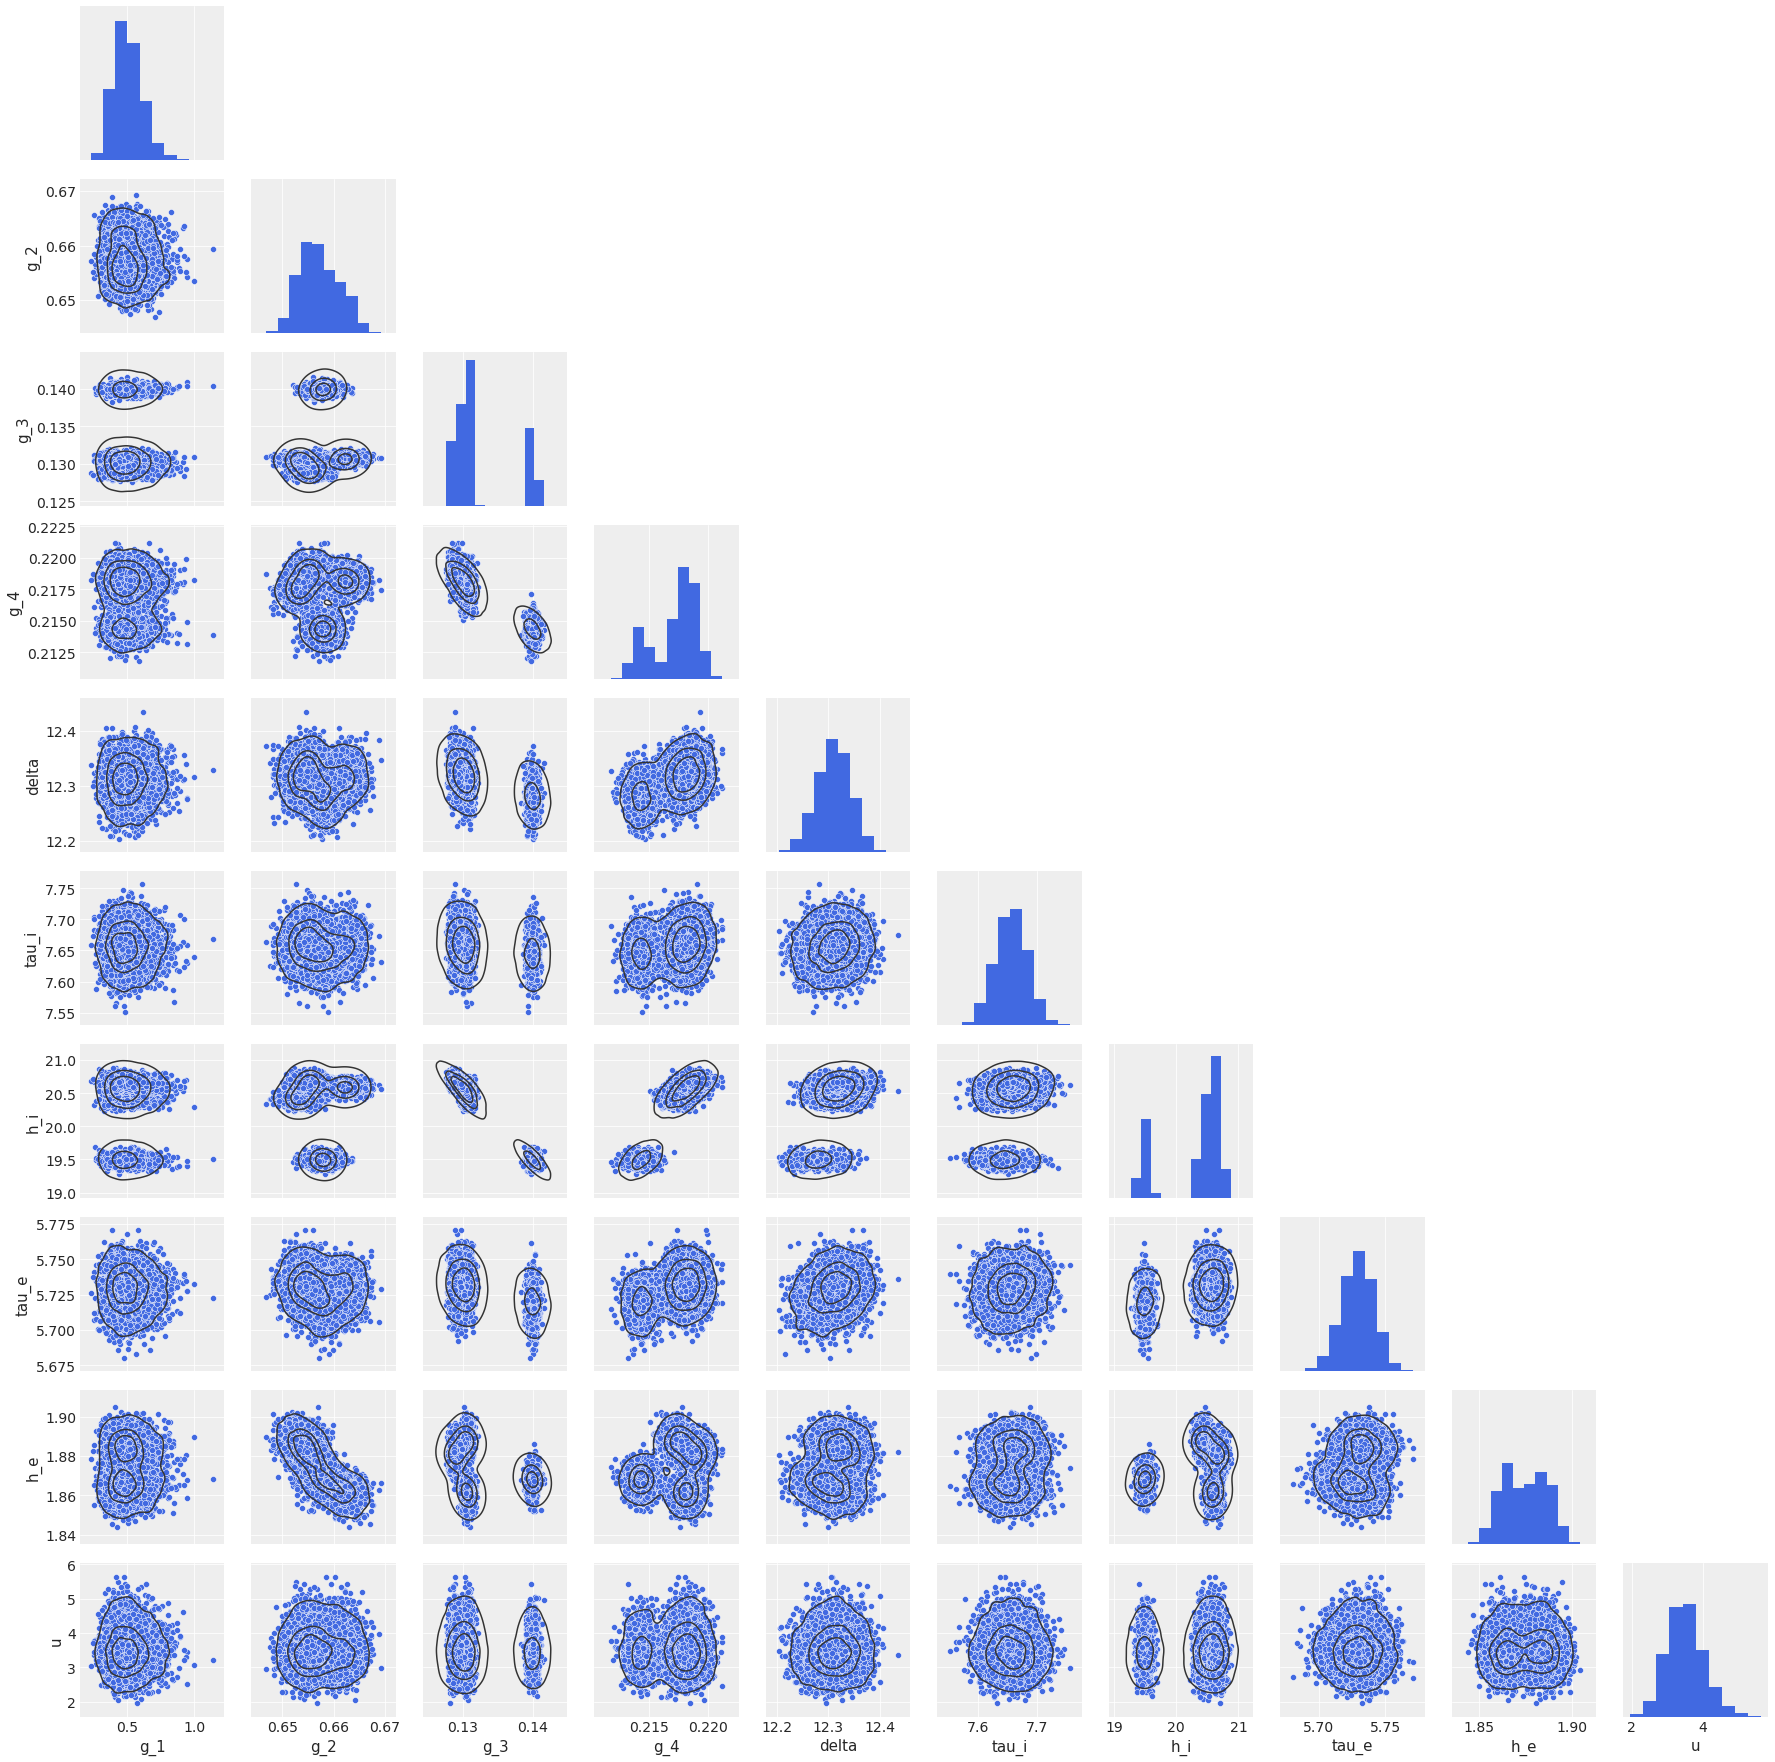

In [71]:
g = sns.PairGrid(pooled_az_4.posterior[my_var_names].to_pandas()[my_var_names], corner=True)
g.map_lower(sns.scatterplot, color='royalblue');
g.map_diag(plt.hist, color='royalblue');
g.map_lower(sns.kdeplot, levels=4, color=".2");

In [72]:
corr_vals=pooled_az_4.posterior[my_var_names].to_pandas()[my_var_names].corr()

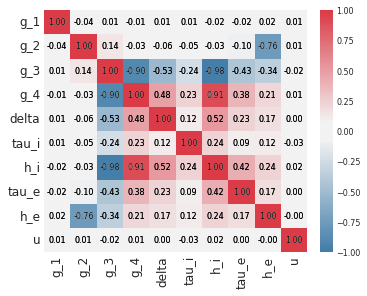

In [73]:
plot_corr(corr_vals.to_numpy(), my_var_names)

#### Stacking
Not solving since the relevant mode of the true generative process is not targeted by none of the chains

In [74]:
az_4 = az_obj.sel(chain=range(4))

In [75]:
pointwise_lp_list = [] 
eps = 0.1 
for ichain in range(az_4.posterior.dims['chain']) :
    density_fit = norm(az_4.posterior['x_hat'][ichain, :, :], eps)
    logp = density_fit.logpdf(data['xpy_obs'])
    pointwise_lp_list.append(logp)
    
try :
    del az_4.log_likelihood
except :
    pass 
az_4.add_groups({'log_likelihood': dict(log_lik=np.array(pointwise_lp_list))})

Create a dictionnary of the different "models" we are going to compare - here each model is one of the chain

In [76]:
name = []
post = []
for i in range(az_4.posterior.dims['chain']) :
    post.append(az_4.sel(chain=[i]))
    name.append(str(i))
    
chains_dict = dict(zip(name, post))

In [77]:
comp_stack = az.compare(chains_dict, method='stacking')
comp_stack

rank    elpd_loo     p_loo  elpd_diff        weight        se       dse  \
0     0  174.724101  9.269822   0.000000  2.387611e-17  8.469209  0.000000   
2     1  174.700192  9.126051   0.023909  5.781502e-01  8.415255  0.797619   
3     2  173.525186  9.577536   1.198915  3.317178e-01  8.706031  1.399609   
1     3  168.154851  9.719521   6.569250  9.013193e-02  8.888763  4.072661   

   warning scale  
0     True   log  
2     True   log  
3     True   log  
1     True   log

In [78]:
stack_weights = np.array(comp_stack.sort_index()['weight'])

Getting weighted samples with arviz

In [79]:
#copy posterior to posterior predictive and add observed_data to be able to use function weight_prediction of arviz
list_chains = list(chains_dict.values())
for ichain in range(len(list_chains)) :
    
    try :
        del list_chains[ichain].observed_data
    except :
        pass 
    list_chains[ichain].add_groups(posterior_predictive=list_chains[ichain].posterior.copy())
    
    try :
        del list_chains[ichain].observed_data
    except :
        pass 
    list_chains[ichain].add_groups({'observed_data': data})

In [80]:
w_post = az.weight_predictions(list_chains, stack_weights)
chains_stacked=w_post.posterior_predictive[my_var_names].to_array().values

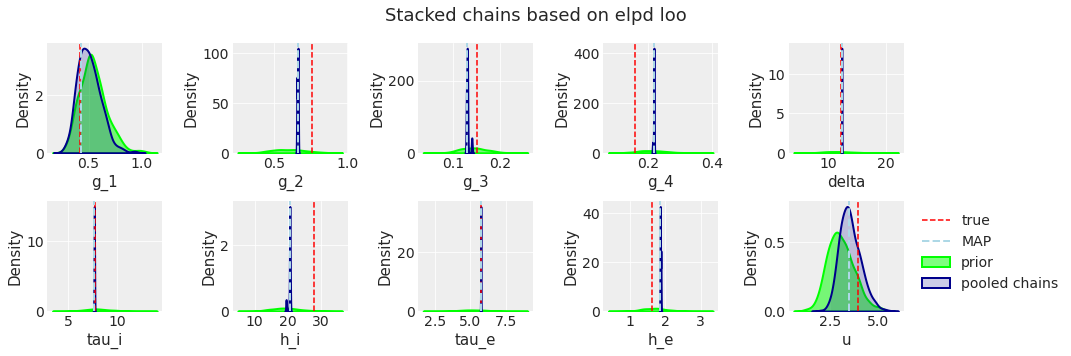

In [81]:
title='Stacked chains based on elpd loo'
plot_posterior_pooled(my_var_names, theta_true,  prior_predictions, chains_stacked, title);

We will pair plot only 4 "chains" as it is already representative of the multimodality 

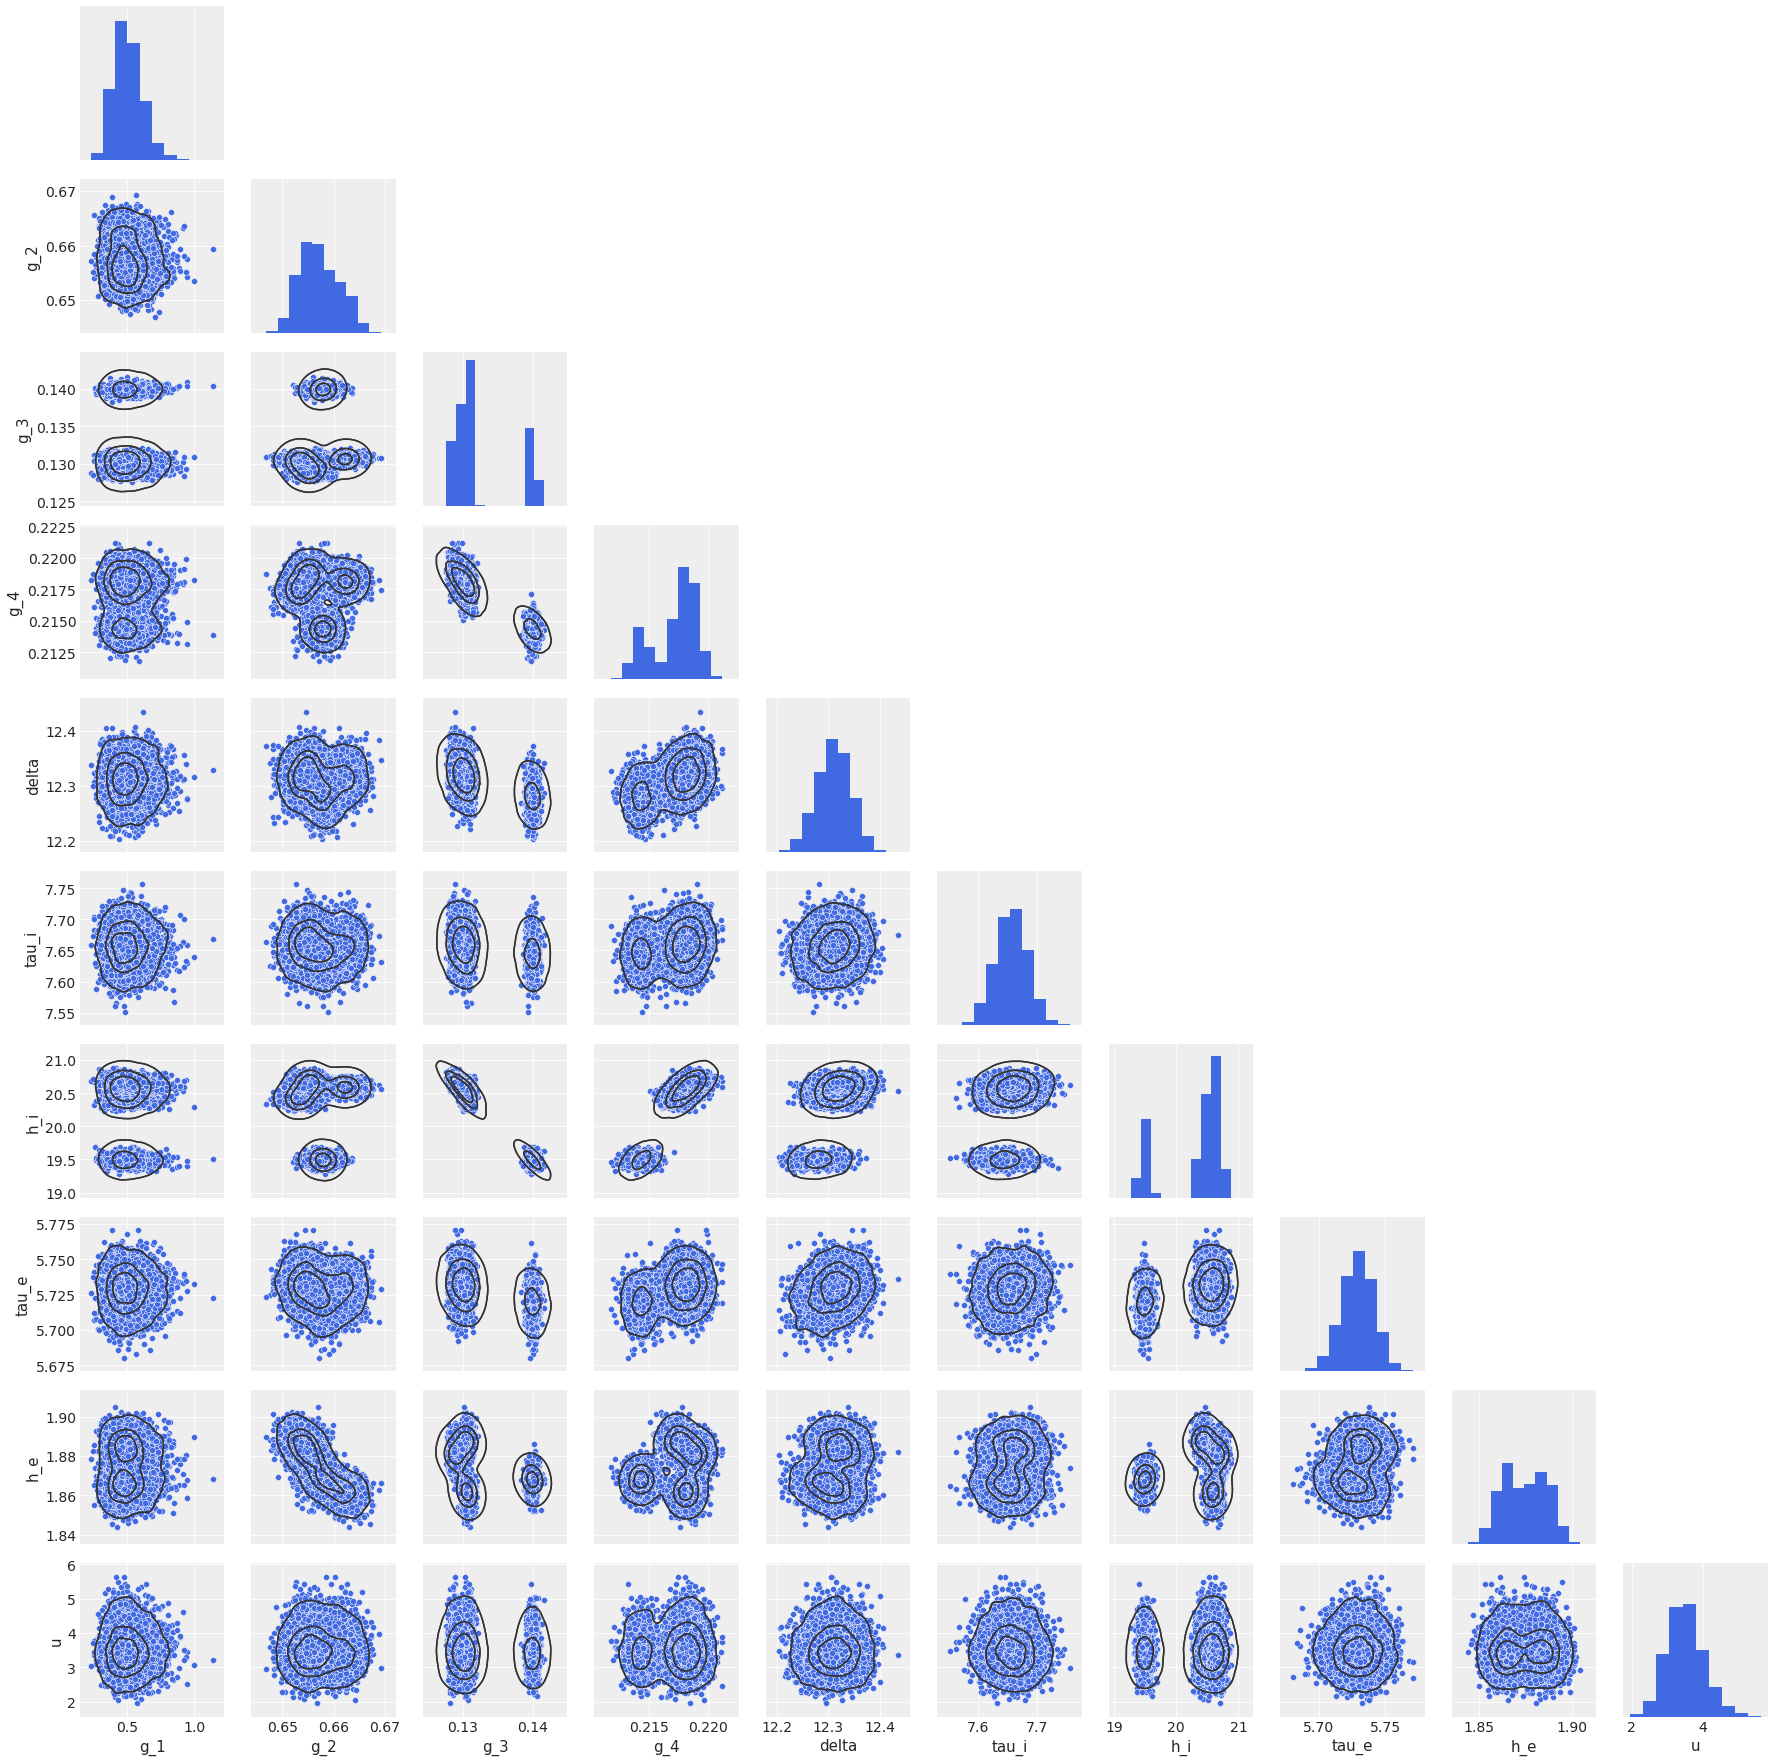

In [82]:
post = pd.DataFrame(dict(zip(my_var_names, chains_stacked)))
g.map_lower(sns.scatterplot, color='royalblue');
g.map_diag(plt.hist, color='royalblue');
g.map_lower(sns.kdeplot, levels=4, color=".2");

In [83]:
corr_vals=post[my_var_names].corr()

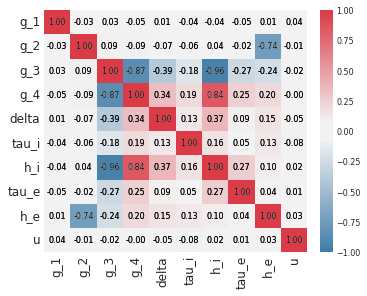

In [84]:
plot_corr(corr_vals.to_numpy(), my_var_names)

# Automatic Differentiation Variational Inference - full rank

We run ADVI with intilization. Without initilization, roughly half of the runs result in non convergence. As encountered in HMC, within "converged" runs, convergence to the relevant mode is not guaranteed. 
With initialization, all the runs converge to the relevant mode.

In [86]:
alg = 'fullrank'
advi_output_dir =  output_dir + 'output_advi/' + alg + '/'
print(advi_output_dir)

/mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_advi/fullrank/


In [87]:
nadvi = 10

In [89]:
for i in range(nadvi) :
    try :
        model.variational(data=data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)
    except :
        model.variational(data=data, inits=inits, algorithm=alg, iter=200000, tol_rel_obj=0.00001,
                          output_dir=advi_output_dir, require_converged=False)

16:26:53 - cmdstanpy - INFO - created output directory: /mnt/data/tng/phd/DCM/DCM_ERP_new/output_cmdstanpy/output_advi/fullrank
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
16:36:28 - cmdstanpy - INFO - Chain [1] start processing
16:46:35 - cmdstanpy - INFO - Chain [1] done processing
16:46:35 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
16:46:41 - cmdstanpy - INFO - Chain [1] start processing
16:56:59 - cmdstanpy - INFO - Chain [1] done processing
16:56:59 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False
16:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:07:33 - cmdstanpy - INFO - Chain [1] done processing
17:07:33 - cmdstanpy - WARNING - The algorithm m

In [90]:
converged = np.zeros(nadvi)
files_converged = []
ELBO_advi = []

i=0
for files in os.listdir(advi_output_dir) :
    if files.endswith('.txt'):
        if convergence_advi(advi_output_dir + files) == 1:
            converged[i] = 1
            i+=1
            files_converged.append(files[:-13])
            Iter, ELBO = advi_elbo(advi_output_dir + files)
            ELBO_advi.append(ELBO)
ELBO_advi = np.array(ELBO_advi)

In [91]:
index_cv = np.argwhere(converged == 1).flatten()
n_advi_converged = int(np.sum(converged))
pct_advi_converged = n_advi_converged / len(converged)
print('Percent of ADVI runs converged:', pct_advi_converged * 100)

Percent of ADVI runs converged: 100.0


Algorithm runs until the end, however it does not guarantee convergence. 

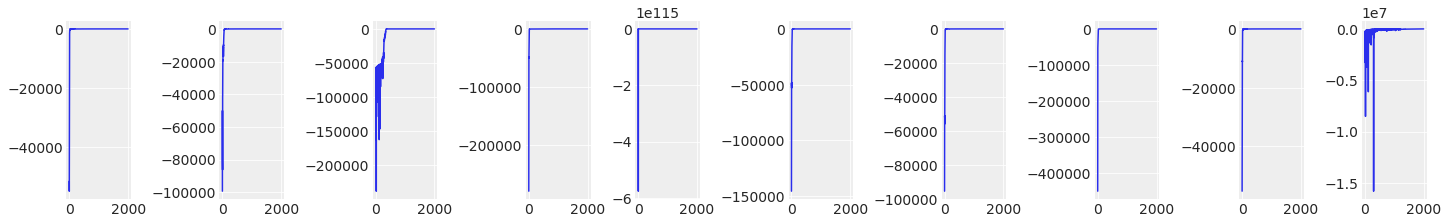

In [92]:
fig, ax = plt.subplots(ncols=n_advi_converged, figsize=(20, 3))
for i in range(n_advi_converged) :
    ax[i].plot(ELBO_advi[i, :])

In [93]:
az_obj = az.from_cmdstan([advi_output_dir + file + '.csv' for file in files_converged[:-1]])

In [94]:
az.summary(az_obj, var_names=my_var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
g_1     0.521  0.132   0.300    0.781      0.001    0.001    8603.0    8735.0   
g_2     0.647  0.086   0.488    0.805      0.001    0.001    8604.0    8566.0   
g_3     0.129  0.025   0.083    0.174      0.000    0.000    5946.0    8607.0   
g_4     0.222  0.038   0.155    0.293      0.000    0.000    9056.0    8864.0   
delta  12.308  0.409  11.544   13.076      0.004    0.003    9146.0    8833.0   
tau_i   7.654  0.097   7.475    7.836      0.001    0.001    8873.0    8651.0   
h_i    21.023  4.034  13.628   28.441      0.043    0.030    8840.0    8726.0   
tau_e   5.742  0.174   5.427    6.085      0.002    0.001    9105.0    8755.0   
h_e     1.937  0.254   1.483    2.430      0.003    0.002    8607.0    8702.0   
u       3.488  0.610   2.367    4.614      0.006    0.004    9347.0    9017.0   

       r_hat  
g_1     1.00  
g_2     1.00  
g_3     1.01  
g_4     1.00  
delta   1.00  
tau_i   1.00  
h_i     1.00  
tau_e   1.00  
h_e     1.00  
u       1.00

In [95]:
chains_pooled = az_obj.posterior[my_var_names].to_array().values.reshape(n_params, -1)
params_map_pooled=calcula_map(chains_pooled)

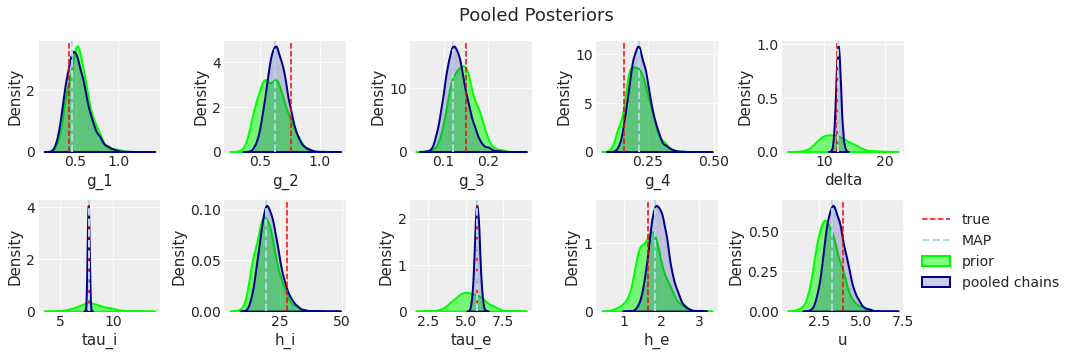

In [96]:
title="Pooled Posteriors"
plot_posterior_pooled(my_var_names, theta_true, prior_predictions, chains_pooled, title);

### Fit and Posterior predictive check 

In [97]:
az_obj.posterior['xpy_model'] = az_obj.posterior['x_hat']

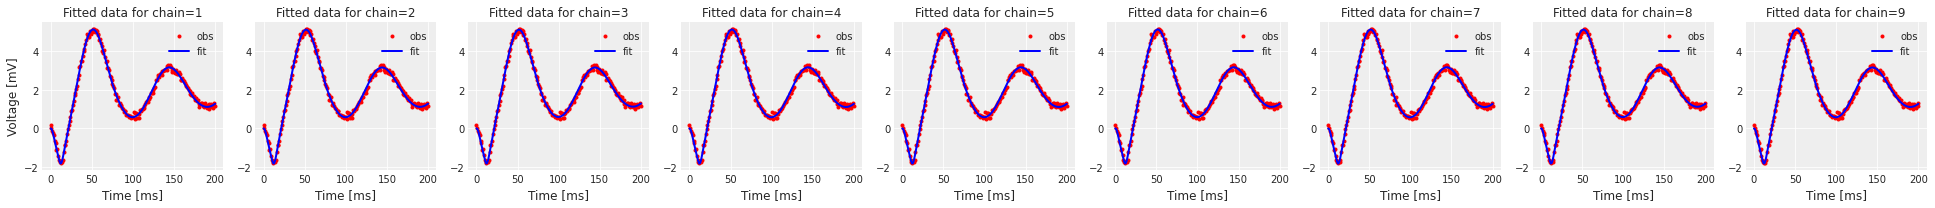

In [98]:
plot_fitted(data, az_obj.posterior) ;

In [99]:
ppc_= az_obj.posterior['x_hat_ppc']
xpy_per05_pooled=np.quantile(ppc_, 0.05, axis=(0, 1))
xpy_per95_pooled=np.quantile(ppc_, 0.95, axis=(0, 1))

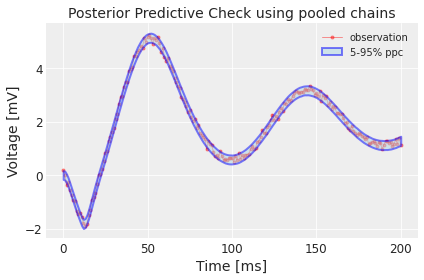

In [100]:
title='Posterior Predictive Check using pooled chains'
plot_posteriorcheck(data, xpy_per05_pooled, xpy_per95_pooled, title)

We will plot joint for only 4 chains as they have all converged. ADVI with full rank exacerbates correlations between parameters compared to HMC

In [101]:
pooled_az_4 = az_obj.sel(chain=range(4), draw=range(200)).stack({'pooled_draw': ["chain", "draw"]})

In [ ]:
with open(output_dir + 'values_' + alg + '_with_inits.pkl', 'wb') as f:
    pickle.dump(pooled_az_4.posterior[my_var_names].to_pandas(), f)

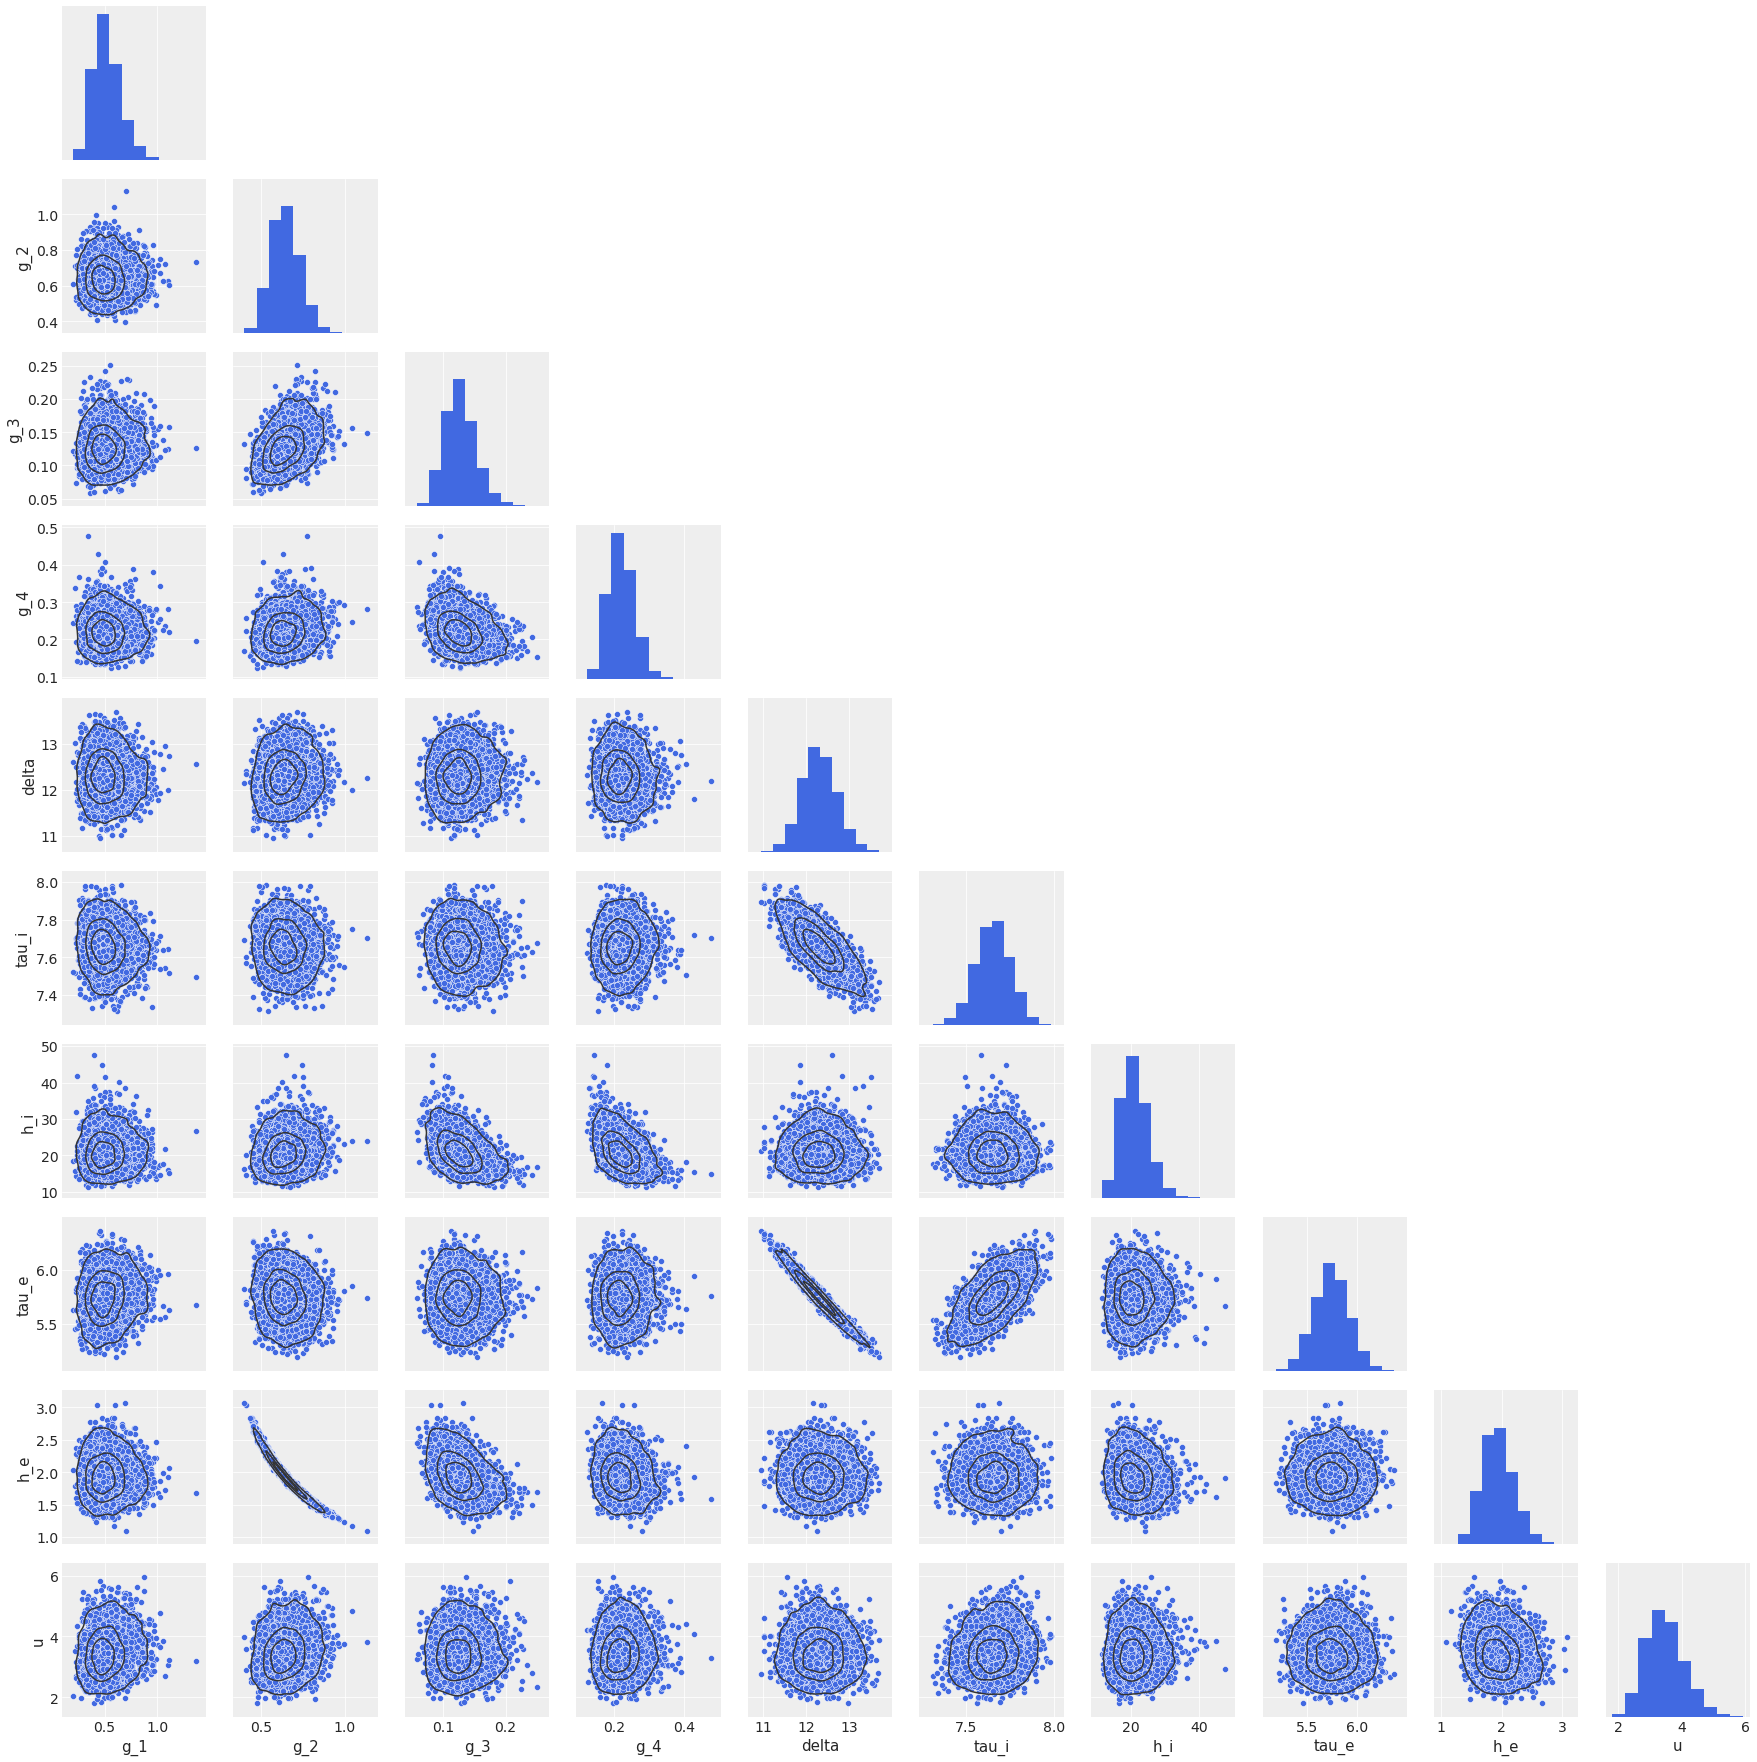

In [102]:
g = sns.PairGrid(pooled_az_4.posterior[my_var_names].to_pandas()[my_var_names], corner=True)
g.map_lower(sns.scatterplot, color='royalblue');
g.map_diag(plt.hist, color='royalblue');
g.map_lower(sns.kdeplot, levels=4, color=".2");

In [103]:
corr_vals=pooled_az_4.posterior[my_var_names].to_pandas()[my_var_names].corr()

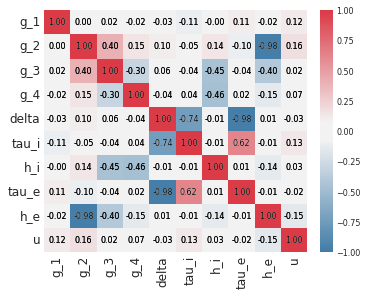

In [104]:
plot_corr(corr_vals.to_numpy(), my_var_names)

In [105]:
#! pip install watermark
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu May 02 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

matplotlib: 3.5.2
arviz     : 0.17.0
pandas    : 1.4.3
numpy     : 1.26.4
sys       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
cmdstanpy : 1.1.0
seaborn   : 0.13.2

Watermark: 2.4.3

